In [1]:
import pickle
from collections import Counter

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster,metrics
import seaborn as sns
import mygene

%matplotlib inline

In [2]:
gard2gene = pd.read_csv("../data/raw/gard2gene.csv")
geneid2sym = {int(i):v for i,v in zip(gard2gene['Gene_ID'],gard2gene['Gene_Symbol']) if not pd.isna(i)}

In [3]:
#Load the knowledge graph
with open("../data/processed/disease_ontograph.pkl", 'rb') as f:
    disease_ontograph = pickle.load(f)
    #Remove unconnected components
components = [i for i in nx.connected_components(disease_ontograph)]
disease_ontograph = disease_ontograph.subgraph(components[0]).copy()

diseases = [n for n in disease_ontograph.nodes if disease_ontograph.nodes[n].get('label') ==  'disease']

In [4]:
#Load the cluster model
N = 250
L = 250
D = 32 
K_dim = 20
m_file = "../data/clusters/kmeans/ontograph_embed_N{0}_L{1}_D{2}_K{3}_KMEANS_KOPT37.pkl".format(N,L,D,K_dim)
with open(m_file, 'rb') as f:
    cluster_model = pickle.load(f)
    
cluster_map = {dis:cluster_model.labels_[i] for i,dis in enumerate(diseases)}

In [5]:
pharos_ligands = pd.read_csv("../data/raw/pharos_all_target_ligands.csv")

In [6]:
pharos_ligands.loc[pharos_ligands['Ligand Name']=="Posaconazole","Ligand Is Drug"] = 1

In [7]:
pharos_ligands.columns

Index(['id', 'UniProt', 'Symbol', 'Ligand Name', 'Ligand Is Drug',
       'Ligand SMILES', 'Ligand PubChem ID', 'Ligand ChEMBL ID',
       'Ligand DrugCentral ID', 'Ligand Description', 'Preferred Term', 'UNII',
       'Ligand Activity', 'Ligand Activity Type', 'Ligand Action',
       'Ligand References', 'Ligand Reference Source', 'Ligand PubMed IDs'],
      dtype='object')

In [8]:
pharos_drugs = pharos_ligands[pharos_ligands['Ligand Is Drug']==1]

In [9]:
TCRD_targets = pd.read_table("../data/raw/TCRDv6.12.4.tsv")
TCRD_targets = TCRD_targets[TCRD_targets['NCBI Gene ID']!='None']
TCRD_targets['NCBI Gene ID'] = TCRD_targets['NCBI Gene ID'].astype('int')

In [10]:
gard_gene_tcrd = gard2gene.merge(TCRD_targets,'left',left_on='Gene_ID',right_on='NCBI Gene ID')
gard_gene_tcrd['Cluster'] = [cluster_map[i] for i in gard_gene_tcrd['GARD_ID']]

cluster_tclin_counts = gard_gene_tcrd[['Cluster','GARD_ID','Gene_ID','TDL']].drop_duplicates().groupby(['Cluster','TDL']).size().reset_index()

In [11]:
cluster_tclin_counts.columns = ['Cluster','TDL','Count']

In [12]:
tclin_order = cluster_tclin_counts.groupby(['Cluster']).agg({'Count':sum}).sort_values('Count',ascending=True).index
wide_df = cluster_tclin_counts.pivot(index='Cluster',columns='TDL',values='Count')

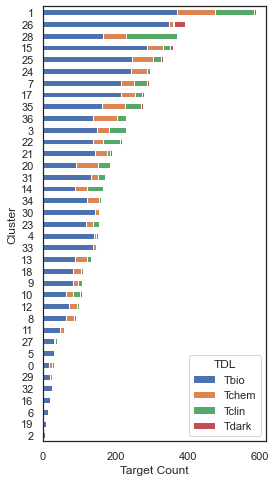

In [13]:
sns.set(rc = {'figure.figsize':(4,8)})
sns.set_style("white")
wide_df.loc[tclin_order,:].plot(kind='barh',stacked=True)
plt.xlabel("Target Count")
plt.savefig('../fig/target_tdl_count.png', dpi=300,bbox_inches='tight')

In [14]:
pharos_uniprot = set(pharos_drugs['UniProt'])
mg = mygene.MyGeneInfo()
mg_uniprot = mg.querymany(list(pharos_uniprot), scopes='uniprot', fields='entrezgene', species='human',returnall=True)
entrez_counts = Counter([i.get('query') for i in mg_uniprot['out'] if i.get('entrezgene')])
uniprot2entrez = {}

for query in mg_uniprot['out']:
    if query.get('entrezgene'):
        if  query['query'] in uniprot2entrez:
            uniprot2entrez[query['query']].append(query['entrezgene'])
        else:
            uniprot2entrez[query['query']] = [query['entrezgene']]

querying 1-1000...done.
querying 1001-1226...done.
Finished.
11 input query terms found dup hits:
	[('P57059', 2), ('P0DP24', 3), ('P49674', 2), ('P24462', 2), ('P69905', 2), ('P0DP25', 3), ('Q59H18'
11 input query terms found no hit:
	['P01857', 'Q6ZSR9', 'P01854', 'O75343', 'Q92753', 'P01861', 'Q7RTR8', 'P59539', 'P01860', 'P01859',


In [15]:
{i:uniprot2entrez[i] for i in uniprot2entrez if len(uniprot2entrez[i])>1}

{'P57059': ['102724428', '150094'],
 'P0DP24': ['801', '805', '808'],
 'P49674': ['102800317', '1454'],
 'P24462': ['100861540', '1551'],
 'P69905': ['3040', '3039'],
 'P0DP25': ['801', '805', '808'],
 'Q59H18': ['100526835', '51086'],
 'P34998': ['1394', '104909134'],
 'P36544': ['89832', '1139'],
 'P0DP23': ['801', '805', '808'],
 'P49356': ['100529261', '2342']}

In [16]:
uniprot2entrez['P0DP23'] = ['801']
uniprot2entrez['P0DP24'] = ['805']
uniprot2entrez['P0DP25'] = ['808']
uniprot2entrez['P49356'] = ['2342']
uniprot2entrez['P57059'] = ['150094']
uniprot2entrez['P36544'] = ['1139']
uniprot2entrez['P69905'] = ['3039']
uniprot2entrez['P49674'] = ['1454']
uniprot2entrez['P34998'] = ['1394']
uniprot2entrez['Q59H18'] = ['51086']
uniprot2entrez['P24462'] = ['1551']

In [17]:
pharos_entrez = [uniprot2entrez.get(i) for i in pharos_drugs['UniProt']]
pharos_entrez = [int(i[0]) if i is not None else i for i in pharos_entrez]
pharos_drugs.insert(2, "Gene_ID", pharos_entrez, True)

In [18]:
pharos_drugs

,id,UniProt,Gene_ID,Symbol,Ligand Name,Ligand Is Drug,Ligand SMILES,Ligand PubChem ID,Ligand ChEMBL ID,Ligand DrugCentral ID,Ligand Description,Preferred Term,UNII,Ligand Activity,Ligand Activity Type,Ligand Action,Ligand References,Ligand Reference Source,Ligand PubMed IDs
14,17974,Q12809,3757.0,KCNH2,mizolastine,1,CN(c1nccc(=O)[nH]1)C1CCN(c2nc3ccccc3n2Cc2ccc(F...,65906,CHEMBL94454,1824.0,a long-acting H1-antihistamine indicated for t...,MIZOLASTINE,244O1F90NA,5.14,Ki,NaN,"Bioorg. Med. Chem. Lett., (2009) 19:15:4380",NaN,19553115
31,17974,Q12809,3757.0,KCNH2,ondansetron,1,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O,4595,CHEMBL46,1992.0,A competitive serotonin type 3 receptor antago...,ONDANSETRON,4AF302ESOS,6.40,IC50,NaN,"Bioorg. Med. Chem. Lett., (2010) 20:22:6538",NaN,20889341
43,8206,P23975,6530.0,SLC6A2,duloxetine,1,CNCC[C@H](Oc1cccc2ccccc12)c1cccs1,60835,CHEMBL1175,972.0,A thiophene derivative and selective NEUROTRAN...,DULOXETINE,O5TNM5N07U,8.40,IC50,NaN,"Bioorg. Med. Chem. Lett., (2009) 19:9:2464",NaN,19329313
48,8449,P31645,6532.0,SLC6A4,imipramine,1,CN(CCCN1c2ccccc2CCc2c1cccc2)C,3696,CHEMBL11,1427.0,The prototypical tricyclic antidepressant. It ...,IMIPRAMINE,OGG85SX4E4,8.46,IC50,NaN,"J. Med. Chem., (2013) 56:22:8955",NaN,23919353
54,15806,P11229,1128.0,CHRM1,oxybutynin,1,CCN(CC#CCOC(=O)C(c1ccccc1)(C1CCCCC1)O)CC,"91505,4634","CHEMBL1133,CHEMBL1231",2028.0,Oxybutynin acts as a competitive antagonist of...,OXYBUTYNIN,K9P6MC7092,9.07,Ki,NaN,"None, None:None:None",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603369,19469,P27361,5595.0,MAPK3,sorafenib,1,CNC(=O)c1nccc(c1)Oc1ccc(cc1)NC(=O)Nc1ccc(c(c1)...,"216239,60150671,139061047","CHEMBL1336,CHEMBL3928540,CHEMBL1200485",2459.0,Sorafenib is a kinase inhibitor that decreases...,SORAFENIB,9ZOQ3TZI87,7.74,IC50,NaN,https://www.ebi.ac.uk/chembl/compound/inspect/...,CHEMBL,NaN
603400,7612,Q8NER1,7442.0,TRPV1,capsaicin,1,COc1cc(CNC(=O)CCCC/C=C/C(C)C)ccc1O,1548943,CHEMBL294199,3064.0,An alkylamide found in CAPSICUM that acts at T...,CAPSAICIN,S07O44R1ZM,5.60,Ki,NaN,"J Med Chem, (2017) 60:19:8246",NaN,28892388
603407,3437,P07949,5979.0,RET,sorafenib,1,CNC(=O)c1nccc(c1)Oc1ccc(cc1)NC(=O)Nc1ccc(c(c1)...,"216239,60150671,139061047","CHEMBL1336,CHEMBL3928540,CHEMBL1200485",2459.0,Sorafenib is a kinase inhibitor that decreases...,SORAFENIB,9ZOQ3TZI87,8.22,IC50,NaN,"J. Med. Chem., (2015) 58:9:3672",NaN,25625428
603467,12099,Q56UN5,80122.0,MAP3K19,erlotinib,1,COCCOc1cc2c(ncnc2cc1OCCOC)Nc1cccc(c1)C#C,"44263854,176870","CHEMBL1079742,CHEMBL553",1045.0,A quinazoline derivative and ANTINEOPLASTIC AG...,ERLOTINIB,J4T82NDH7E,7.60,Kd,NaN,https://www.ebi.ac.uk/chembl/compound/inspect/...,CHEMBL,NaN


In [19]:
gard_gene_pharos = gard2gene.merge(pharos_drugs,'left',left_on='Gene_ID',right_on='Gene_ID')
gard_gene_pharos['Cluster'] = [cluster_map[i] for i in gard_gene_pharos['GARD_ID']]
gard_gene_pharos = gard_gene_pharos.dropna(subset=['id'])
cluster_drug_counts = gard_gene_pharos[['Cluster','Ligand DrugCentral ID']].drop_duplicates().groupby(['Cluster']).size()

In [20]:
cluster_drug_counts = cluster_drug_counts.reset_index()
cluster_drug_counts.columns = ['Cluster','Count']
y_pos = cluster_drug_counts.sort_values('Count',ascending=False).Cluster

In [21]:
set(cluster_model.labels_).difference(cluster_drug_counts['Cluster'])

{2, 16, 19}

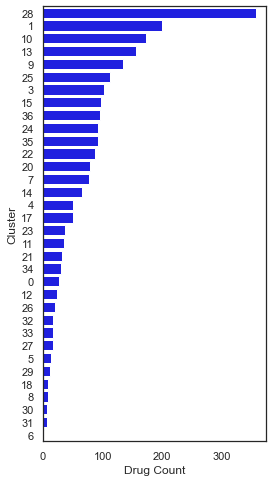

In [22]:
sns.set(rc = {'figure.figsize':(4,8)})
sns.set_style("white")
sns.barplot(x="Count", y="Cluster", data=cluster_drug_counts,orient='h',order=y_pos,color='blue')
plt.xlabel("Drug Count")
plt.savefig('../fig/cluster_drug_count.png', dpi=300,bbox_inches='tight')

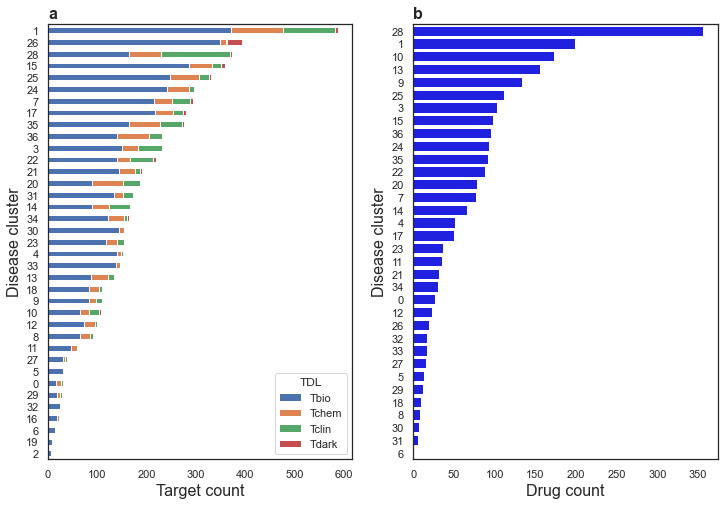

In [48]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_style("white")
fig, axs = plt.subplots(ncols=2)
wide_df.loc[tclin_order,:].plot(kind='barh',stacked=True,ax=axs[0])
axs[0].set_xlabel("Target count",fontsize=16)
axs[0].set_ylabel("Disease cluster",fontsize=16)
axs[0].set_title('a', size=16, weight='bold', loc='left')
sns.barplot(x="Count", y="Cluster", data=cluster_drug_counts,orient='h',order=y_pos,color='blue',ax=axs[1])
axs[1].set_xlabel("Drug count",fontsize=16)
axs[1].set_ylabel("Disease cluster",fontsize=16)
axs[1].set_title('b', size=16, weight='bold', loc='left')
plt.savefig('../fig/cluster_drug_target_count.png', dpi=300,bbox_inches='tight')

In [23]:
gard2gene[gard2gene['GARD_Disease']=='Glioblastoma']

,GARD_ID,GARD_Disease,Disease_Gene_Association,Gene_Symbol,HGNC,Gene_ID
4984,GARD:0002491,Glioblastoma,Part of a fusion gene in,EGFR,3236,1956.0
4994,GARD:0002491,Glioblastoma,Part of a fusion gene in,TACC3,11524,10460.0
5226,GARD:0002491,Glioblastoma,Part of a fusion gene in,TACC1,11522,6867.0
5251,GARD:0002491,Glioblastoma,Biomarker tested in,PPARG,9236,5468.0
5279,GARD:0002491,Glioblastoma,Part of a fusion gene in,SEPTIN14,33280,346288.0
5524,GARD:0002491,Glioblastoma,Part of a fusion gene in,FGFR1,3688,2260.0
5606,GARD:0002491,Glioblastoma,Part of a fusion gene in,FGFR3,3690,2261.0
5940,GARD:0002491,Glioblastoma,Biomarker tested in,IDH1,5382,3417.0
5943,GARD:0002491,Glioblastoma,Biomarker tested in,NFKBIA,7797,4792.0
6161,GARD:0002491,Glioblastoma,Disease-causing somatic mutation(s) in,LZTR1,6742,8216.0
